In [106]:
%reset -f
import lmfit
import matplotlib.pyplot as plt
import pystan
import emcee
from scipy.optimize import curve_fit
from lmfit import Model
import matplotlib
import numpy as np

In [107]:
%matplotlib inline
def intrinsic_func(t,mu,dt):
    return mu*np.sin(t+dt)/np.sqrt(t+dt)

t_max=10.0; t_min=0.0; t_range=t_max-t_min; Ndata=200;
t=t_min+np.random.rand(Ndata)*t_range;t=np.sort(t)
sigft=0.05+np.random.rand(len(t))
#a slight shift is given because fitting may have problem with a very small \sigma 
print(np.amin(t), np.amax(t))


0.00700752982014663 9.995978615055511


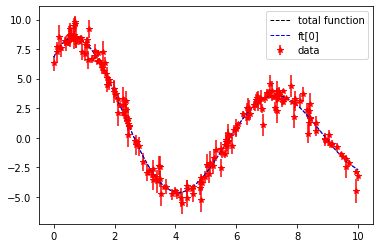

In [110]:
#mu and dt for the images
mu_l=[10.0,15.0,3.5,9.0]
dt_l=[0.5,1.57,0.5,-1.57]
#for simplicity just consider the 1st NI images for now
NI=1; #just take one signal/image 
ft=np.zeros((NI,Ndata))
for i in np.arange(NI): 
    ft[i]=intrinsic_func(t,mu_l[i],dt_l[i])
    
ft_total=np.sum(ft,axis=0)

y=np.random.normal(ft_total, sigft)#this is my data

plt.errorbar(t,y,yerr=sigft,fmt='r*',label=r"data") #data
plt.plot(t,ft_total,c='k',lw=1.0,ls="--", label=r"total function")
clr=["b","g","c"]
for i in range(NI):
    plt.plot(t,ft[i],c=clr[i],lw=1.0,ls="--", label=r"ft[%d]"%(i))

plt.legend(loc=0)
plt.show()

In [111]:
#with lmfit minimization
p = lmfit.Parameters()
p.add_many(('mu1', 2.0, True, 0.1,20.0))
p.add('dt1', value=0.50, min=0.0, max=2.0)
def residual(p):
    v = p.valuesdict()
    return (v['mu1']*np.sin(t+v['dt1'])/np.sqrt(t+v['dt1']) - y)/sigft
print(p)
mi = lmfit.minimize(residual, p, method='leastsq', nan_policy='omit');
lmfit.printfuncs.report_fit(mi.params, min_correl=0.5)
print(mi)
#p.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2))

#res = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=300, steps=1000, thin=7, nwalkers=200,
#                     params=mi.params, is_weighted=False)
#lmfit.report_fit(res.params)

Parameters([('mu1', <Parameter 'mu1', 2.0, bounds=[0.1:20.0]>), ('dt1', <Parameter 'dt1', 0.5, bounds=[0.0:2.0]>)])
[[Variables]]
    mu1:  10.0183504 +/- 0.03408520 (0.34%) (init = 2)
    dt1:  0.50407021 +/- 0.00432993 (0.86%) (init = 0.5)


In [113]:
#with lmfit emcee (MCMC)
p = lmfit.Parameters()
p.add_many(('mu1', 2.0, True, 0.2,20.0))
p.add('dt1', value=0.50, min=0.0, max=2.0)
def residual(p):
    v = p.valuesdict()
    return (v['mu1']*np.sin(t+v['dt1'])/np.sqrt(t+v['dt1']) - y)/sigft


p.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2))

res = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=300, steps=1000, thin=7, nwalkers=50,
                     params=p, is_weighted=False)
lmfit.report_fit(res.params)

100%|██████████| 1000/1000 [00:04<00:00, 224.23it/s]

[[Variables]]
    mu1:        10.0169340 +/- 0.03385491 (0.34%) (init = 2)
    dt1:        0.50407597 +/- 0.00422887 (0.84%) (init = 0.5)
    __lnsigma:  0.01845443 +/- 0.05123959 (277.65%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(mu1, dt1) =  0.362


odict_values([10.016934032288567, 0.5040759747330593, 0.018454433732876002])


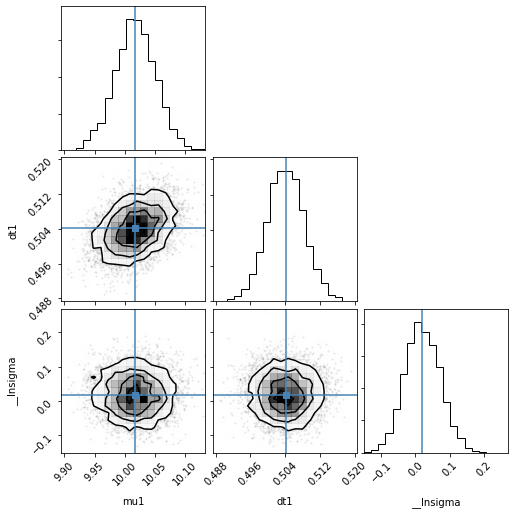

In [114]:
import corner
print(res.params.valuesdict().values())
emcee_plot = corner.corner(res.flatchain, labels=res.var_names,
                           truths=list(res.params.valuesdict().values()))

In [118]:
#pystan: assuming the model=mu*sin(t+dt)/np.sqrt(t+dt);
model = """
data {
    int<lower=0> N;
    int<lower=0> ni;
    vector[N] t;
    vector[N] y;
    vector[N] yerror;
}
parameters {
    real<lower=0.2, upper=20> mu;
    real <lower=0, upper=2> dt;
    
}
model {
    real dum;
    real dtt;
    for(i in 1:N) {
        dum=mu*sin(t[i]+dt)/sqrt(t[i]+dt);
        //y[i] ~ normal(dum, yerror[i]);
        target+=normal_lpdf(y[i]|dum,yerror[i]);
    }
}
"""
# Put our data in a dictionary
data = {'N': Ndata,'ni':NI, 't': t, 'y': y, 'yerror':sigft}

# Compile the model
sm = pystan.StanModel(model_code=model)

# Train the model and generate samples
fit = sm.sampling(data=data, iter=2000, chains=4, warmup=400, thin=3, seed=101)
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d11ec89845898150ef484563d29d3419 NOW.


Inference for Stan model: anon_model_d11ec89845898150ef484563d29d3419.
4 chains, each with iter=2000; warmup=400; thin=3; 
post-warmup draws per chain=534, total post-warmup draws=2136.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    10.02  7.4e-4   0.03   9.95   10.0  10.02  10.04  10.08   2044    1.0
dt      0.5  9.4e-5 4.2e-3    0.5    0.5    0.5   0.51   0.51   2032    1.0
lp__ -107.7    0.02   0.98 -110.2 -108.1 -107.4 -107.0 -106.7   2057    1.0

Samples were drawn using NUTS at Wed Nov 20 11:28:26 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Upto this point we see that the minimization, MCMC, Pystan, HMC, all work well to fit one signal when we assume the correct template for the intrinsic signal.


In [193]:
#pystan: modelling the intrinsic function with NP parameters and interpolation
#No parameter for: scaling mu and time delay dt
model = """
data {
    int<lower=0> N;
    int<lower=5> NP;
    vector[N] t;
    vector[N] y;
    vector[N] yerror;
    real trange;
}
parameters {
    vector <lower=-20.0, upper=20.0> [NP] P;
}

model {
    real td=trange/(NP-1); //the separation between the free nodes, depends upon trange, NP and range of dt
    real dum_t;
    int ti;
    
    real mod_intr_f;
    
    for(i in 1:N) {
        dum_t=t[i];
        ti=1;
        //because there is no real to int conversion in stan we have to do it in this way
        while(dum_t>ti*td){
            ti=ti+1;
        }
        mod_intr_f=P[ti+1]+((P[ti+1]-P[ti])/td)*(dum_t-ti*td); //interpolation           
        //y[i] ~ normal(mod_intr_f, yerror[i]);
        target+=normal_lpdf(y[i]|mod_intr_f, yerror[i]);
    }
}
"""
NP=21;#How many free nodes we choose

data = {'N': Ndata,'NP':NP, 't': t, 'y': y, 'yerror':sigft,'trange':t_range}

sm = pystan.StanModel(model_code=model)

fit = sm.sampling(data=data, iter=2400, chains=4, warmup=400, thin=3, seed=101)
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c81639ca3c010e7d59f0f2b4143719d1 NOW.


Inference for Stan model: anon_model_c81639ca3c010e7d59f0f2b4143719d1.
4 chains, each with iter=2400; warmup=400; thin=3; 
post-warmup draws per chain=667, total post-warmup draws=2668.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
P[1]    7.04  3.1e-3   0.17   6.72   6.93   7.05   7.16   7.36   2829    1.0
P[2]    8.77  2.0e-3    0.1   8.57    8.7   8.77   8.84   8.97   2729    1.0
P[3]    8.18  1.1e-3   0.06   8.07   8.14   8.18   8.22   8.31   2729    1.0
P[4]    6.44  1.1e-3   0.06   6.32    6.4   6.44   6.48   6.56   2728    1.0
P[5]    3.93  1.6e-3   0.08   3.76   3.87   3.93   3.98   4.08   2504    1.0
P[6]    0.75  9.7e-4   0.05   0.65   0.71   0.75   0.79   0.86   3029    1.0
P[7]   -1.99  3.2e-3   0.17  -2.32   -2.1  -1.99  -1.87  -1.66   2802    1.0
P[8]   -3.96  2.4e-3   0.13  -4.21  -4.04  -3.96  -3.87  -3.71   2795    1.0
P[9]    -4.7  4.3e-3   0.23  -5.13  -4.85  -4.69  -4.55  -4.27   2791    1.0
P[10]  -4.48  2.4e-3   0.13  -4.74  -4.57  

P's are calculated at t=  [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10. ]


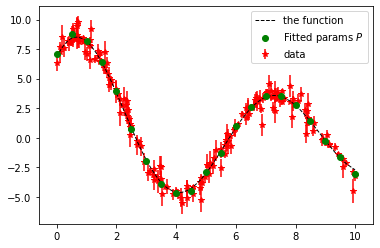

In [194]:
pp1=fit.get_posterior_mean()
pos_mean=np.mean(pp1,axis=1)#mean of the posterior
P_mean=pos_mean[np.arange(0,len(pos_mean)-1)]
#len(P_mean)
tp=np.linspace(0,t_range,NP)
print("P's are calculated at t= ",tp)
plt.errorbar(t,y,yerr=sigft,fmt='r*',label=r"data", zorder=1) #data
plt.plot(t,ft_total,c='k',lw=1.0,ls="--", label=r"the function", zorder=2)
plt.scatter(tp,P_mean,c='g', label=r"Fitted params $P$", zorder=3)

plt.legend(loc=0)
plt.show()

The fitting with NP parameters (lets call it "interporlation fitting") is perfect. We just need NP (whatever we choose) free nodes to fit one signal/image. Any additional scaling (mu) and time delay (dt) here have no meaning, and those would possibly cause degeneracy with P's. Let us check that below by adding only a scaling mu:  

In [195]:
#pystan: modelling the intrinsic function with NP parameters and interpolation
#We add scaling mu as a parameter below, We could also add time delay if we want to
model = """
data {
    int<lower=0> N;
    int<lower=5> NP;
    vector[N] t;
    vector[N] y;
    vector[N] yerror;
    real trange;
    real dt_min;
    real dt_max;
}
parameters {
    real<lower=0.02, upper=20> mu ; //just added a scaling
    //real <lower=dt_min, upper=dt_max> dt; //not using it right now
    vector <lower=-100.0, upper=100.0> [NP] P;
    real sig2;
    
}
model {
    real dum;
    real td=trange/(NP-1);//no time delay yet
    real dum_t;
    int ti;
    
    real mod_intr_f;
    
    for(i in 1:N) {
        dum_t=t[i];
        //dum_t=dum_t+dt;
        ti=1;
        //because there is no real to int conversion in stan we have to do it in this way
        while(dum_t>ti*td){
            ti=ti+1;
        }
        mod_intr_f=P[ti+1]+((P[ti+1]-P[ti])/td)*(dum_t-ti*td);
        dum=mu*mod_intr_f;// using the scaling/amplitude mu
            
        //y[i] ~ normal(dum, yerror[i]);
        target+=normal_lpdf(y[i]|dum, sqrt(yerror[i]*yerror[i]+sig2));
    }
}
"""
NP=26; 
data = {'N': Ndata,'NP':NP, 't': t, 'y': y, 'yerror':sigft,'trange':t_range,'dt_min':-2.0,'dt_max':2.0}

sm = pystan.StanModel(model_code=model)

fit1 = sm.sampling(data=data, iter=3000, chains=4, warmup=400, thin=3, seed=101)
print(fit1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e624cc90d8ba431fe84fdd2f5c6ba56f NOW.


Inference for Stan model: anon_model_e624cc90d8ba431fe84fdd2f5c6ba56f.
4 chains, each with iter=3000; warmup=400; thin=3; 
post-warmup draws per chain=867, total post-warmup draws=3468.

        mean se_mean     sd    2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.09  1.9e-4 3.9e-3    0.09   0.09   0.09   0.09    0.1    410   1.01
P[1]   78.13    0.17   4.15   68.87  75.67  78.52  81.03  85.27    587   1.01
P[2]   94.86    0.19   4.09   84.37  92.91  95.93  97.95  99.74    474   1.01
P[3]   95.38    0.19   3.93    85.1  93.48  96.39  98.38  99.84    424   1.01
P[4]   84.26    0.18   3.77   74.97  82.31  85.02  86.89  89.72    436   1.01
P[5]   67.06    0.14   2.93   59.74  65.57  67.68  69.14   71.2    452   1.01
P[6]   43.15    0.09   2.44   37.75  41.66  43.35  44.78  47.54    715    1.0
P[7]   15.23    0.04   1.08    13.1  14.52  15.23  15.95  17.35    905    1.0
P[8]   -8.35    0.03    1.7  -11.73  -9.47  -8.35  -7.22  -5.05   2633    1.0
P[9]  -34.87    0.07   2.52  -39.

(1, 3468)
(3468, 2)


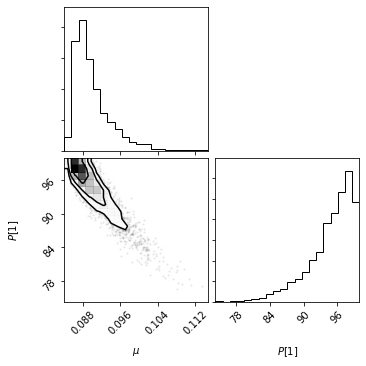

In [196]:
la = fit1.extract(permuted=True)
mu_pos = np.vstack((la['mu'])).T
print(mu_pos.shape)
P_pos=np.vstack((la['P'])).T
postsamples = np.vstack((mu_pos, P_pos[1])).T
print(postsamples.shape)
fig = corner.corner(postsamples, labels=[r"$\mu$", r"$P[1]$"])
#fig.savefig('PyStan.png')

mean of mu= 0.08949312748065627
P's are calculated at t=  [ 0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8  5.2
  5.6  6.   6.4  6.8  7.2  7.6  8.   8.4  8.8  9.2  9.6 10. ]


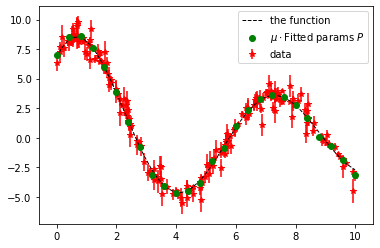

In [191]:
pp1=fit1.get_posterior_mean()
pos_mean=np.mean(pp1,axis=1)#mean of the posterior
P_mean=pos_mean[np.arange(1,len(pos_mean)-2)]
mu=pos_mean[0]; print("mean of mu=",mu)
tp=np.linspace(0,t_range,NP)
print("P's are calculated at t= ",tp)
plt.errorbar(t,y,yerr=sigft,fmt='r*',label=r"data", zorder=1) #data
plt.plot(t,ft_total,c='k',lw=1.0,ls="--", label=r"the function", zorder=2)
plt.scatter(tp,mu*P_mean,c='g', label=r"$\mu \cdot $Fitted params $P$", zorder=3)

plt.legend(loc=0)
plt.show()

We see that the fitting starts to struggle. I believe that is because P's are now having degeracies with the scaling/amplitude mu: $P_i \propto 1/\mu$. If we add time delay to the fitting we will only get more degeneracy.

**This notebook also showed that at least this part of our code has no bug**